In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception,VGG16,ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dataset/HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
df.dx.value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

In [ ]:
#keeping all the values of bkl type
bkl = df[df['dx'] == 'bkl']
#keeping all the values of mel type
mel = df[df['dx'] == 'mel']
bcc = df[df['dx'] == 'bcc']
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [ ]:
data = pd.concat([bkl, mel, bcc])
data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
2971,HAM_0001573,ISIC_0028542,bcc,histo,45.0,male,chest
2972,HAM_0001215,ISIC_0025260,bcc,histo,70.0,male,back
2973,HAM_0001215,ISIC_0031531,bcc,histo,70.0,male,back
2974,HAM_0005026,ISIC_0028978,bcc,histo,40.0,female,abdomen


In [ ]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
base_skin_dir = '/content/drive/MyDrive/Dataset/'

In [ ]:
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [ ]:
data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes

data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Dataset/HAM10000_images...,Benign keratosis-like lesions,1
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Dataset/HAM10000_images...,Benign keratosis-like lesions,1
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Dataset/HAM10000_images...,Benign keratosis-like lesions,1
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/MyDrive/Dataset/HAM10000_images...,Benign keratosis-like lesions,1
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/MyDrive/Dataset/HAM10000_images...,Benign keratosis-like lesions,1


In [ ]:
data.cell_type.value_counts()

cell_type
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Name: count, dtype: int64

In [ ]:
data['age'].fillna((data['age'].mean()), inplace=True)

In [ ]:
IMAGE_SIZE = 71
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  return img
train_img = []
for img_name in tqdm(data['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 2726/2726 [27:43<00:00,  1.64it/s]


In [ ]:
X = np.array(train_img,np.float32)/255
print(X.shape)

(2726, 71, 71, 3)


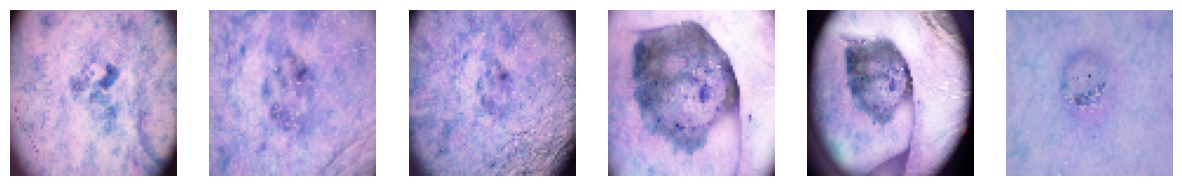

In [ ]:
plt.figure(figsize=(15,12))
for i in range(1,7,1):
    plt.subplot(1,6,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [ ]:
y = np.array(data['cell_type_idx'])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=28,stratify=y)
x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.1,random_state=28,stratify=y_train)

In [ ]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 3)
y_val = to_categorical(y_val , num_classes=3)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], *(71, 71, 3))
x_test = x_test.reshape(x_test.shape[0], *(71, 71, 3))
x_val = x_val.reshape(x_val.shape[0], *(71, 71, 3))

In [ ]:
training_shape = (71,71,3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)
for layer in base_model.layers:
    layer.trainable = True

83683744/83683744 [==============================] - 5s 0us/step


In [ ]:
n_classes = 3
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.2)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [ ]:
optimizer = SGD(lr=0.01, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 71, 71, 3)]          0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 35, 35, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 35, 35, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 35, 35, 32)           0         ['block1_conv1_bn[0][0]'] 

In [ ]:
n_epoch = 20
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1,
                           mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5,
                              verbose=1, mode='auto')

In [ ]:
history = model.fit(x_train,
                    y_train,
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val)
                   )

Epoch 1/20
69/69 [==============================] - 31s 149ms/step - loss: 0.9502 - accuracy: 0.5365 - val_loss: 1.0410 - val_accuracy: 0.4268 - lr: 0.0100
Epoch 2/20
69/69 [==============================] - 5s 77ms/step - loss: 0.6045 - accuracy: 0.7463 - val_loss: 0.7247 - val_accuracy: 0.6463 - lr: 0.0100
Epoch 3/20
69/69 [==============================] - 5s 77ms/step - loss: 0.3454 - accuracy: 0.8627 - val_loss: 0.8240 - val_accuracy: 0.6667 - lr: 0.0100
Epoch 4/20
69/69 [==============================] - 5s 78ms/step - loss: 0.2044 - accuracy: 0.9248 - val_loss: 0.7223 - val_accuracy: 0.7561 - lr: 0.0100
Epoch 5/20
69/69 [==============================] - 5s 74ms/step - loss: 0.1477 - accuracy: 0.9461 - val_loss: 0.8027 - val_accuracy: 0.7683 - lr: 0.0100
Epoch 6/20
69/69 [==============================] - 5s 76ms/step - loss: 0.1597 - accuracy: 0.9425 - val_loss: 0.8347 - val_accuracy: 0.7520 - lr: 0.0100
Epoch 7/20
69/69 [==============================] - 5s 74ms/step - loss: 0

In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = y_test

print("Predicted Class Distribution:", np.bincount(predicted_classes))
print("True Class Distribution:", np.bincount(true_classes))

9/9 [==============================] - 0s 33ms/step
Predicted Class Distribution: [ 60 101 112]
True Class Distribution: [ 52 110 111]


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(true_classes, predicted_classes, average='weighted')
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')

print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

F1 Score: 0.8008887302707948
Precision: 0.8023465847369667
Recall: 0.8021978021978022


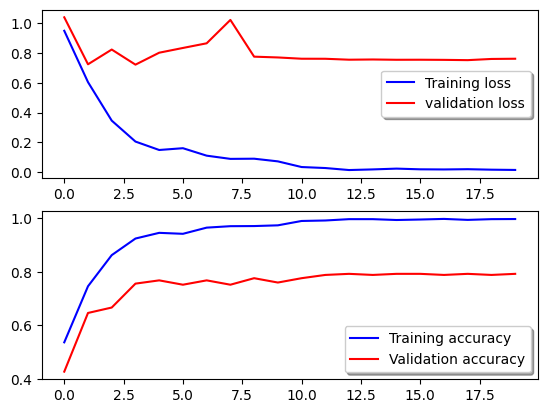

In [ ]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)